In [1]:
# CelebAMask-HQ Dataset: https://drive.google.com/file/d/1badu11NqxGf6qM3PTTooQDJvQbejgbTv/view
# predict: https://github.com/zllrunning/face-parsing.PyTorch

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import sys
sys.path.append('/content/gdrive/My Drive')

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

In [5]:
from logger import setup_logger
from model import BiSeNet

import torch

import os
import os.path as osp
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2

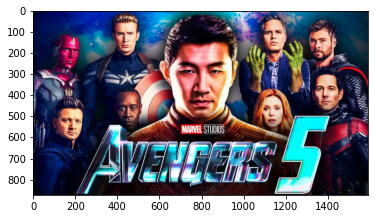

In [6]:
face_cascade = cv2.CascadeClassifier('/content/gdrive/MyDrive/haarcascade_frontalface_default.xml')
img = cv2.imread('/content/gdrive/MyDrive/faces_data/sample/sample-0.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

In [7]:
img_copy = img.copy()
gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

In [8]:
net = BiSeNet(n_classes=19)
net.cuda()
save_pth = osp.join('/content/gdrive/MyDrive/faces_data/res/cp', '79999_iter.pth') # weights
print(save_pth)
net.load_state_dict(torch.load(save_pth))
net.eval()

to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

/content/gdrive/MyDrive/faces_data/res/cp/79999_iter.pth


In [11]:
for (x, y, w, h) in faces: 
    img = img_copy[y:y+h, x:x+w,:]
    with torch.no_grad():
        img = Image.fromarray(img)
        img_size = img.size
        image = img.resize((512, 512), Image.BILINEAR)
        img = to_tensor(image)
        img = torch.unsqueeze(img, 0)
        img = img.cuda()
        out = net(img)[0]
        parsing = out.squeeze(0).cpu().numpy().argmax(0)
    

    points = []
    for row in range(parsing.shape[0]):
      for col in range(parsing.shape[1]):
        if parsing[row][col] != 0 and parsing[row][col] < 14:
          points += [[row, col]]
    points = np.asarray(points)

    im = np.array(image)
    im_blur = im.copy()
    im_blur[:, :] = cv2.blur(im[:,:], (100, 100))

    final = im.copy()
    for i in points:
        for j in i:
            final[i,j] = im_blur[i,j]

    final = Image.fromarray(final)
    final = final.resize(img_size, Image.BILINEAR)
    final = np.array(final)
    
    img_copy[y:y+h, x:x+w,:] = final.copy()

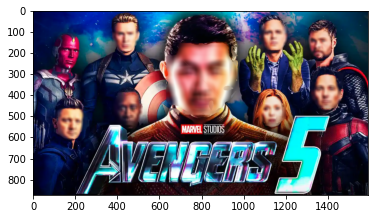

In [12]:
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB));